# Compose: Training a model to generate music

In [28]:
import os
import pickle
import numpy
import pydot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

## Set parameters

In [29]:
# run params
section = 'compose'
run_id = '0006'
genre_name = 'jazz'
composer_name='MilesDavis'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

## Extract the notes

In [30]:
data_folder

'data/jazz/MilesDavis'

In [31]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

17 files in total
1 Parsing data/jazz/MilesDavis/MilesDavis_BitchesBrew-1_FINAL.mid
2 Parsing data/jazz/MilesDavis/MilesDavis_Oleo-1_FINAL.mid
3 Parsing data/jazz/MilesDavis/MilesDavis_Eighty=One_FINAL.mid
4 Parsing data/jazz/MilesDavis/MilesDavis_K.C.Blues_FINAL.mid
5 Parsing data/jazz/MilesDavis/MilesDavis_MilesRunsTheVoodooDown-1_FINAL.mid
6 Parsing data/jazz/MilesDavis/MilesDavis_Agitation_FINAL.mid
7 Parsing data/jazz/MilesDavis/MilesDavis_TuneUp_FINAL.mid
8 Parsing data/jazz/MilesDavis/MilesDavis_E.S.P._FINAL.mid
9 Parsing data/jazz/MilesDavis/MilesDavis_Orbits_FINAL.mid
10 Parsing data/jazz/MilesDavis/MilesDavis_BluesByFive_FINAL.mid
11 Parsing data/jazz/MilesDavis/MilesDavis_SoWhat_FINAL.mid
12 Parsing data/jazz/MilesDavis/MilesDavis_VierdBlues_FINAL.mid
13 Parsing data/jazz/MilesDavis/MilesDavis_BitchesBrew-2_FINAL.mid
14 Parsing data/jazz/MilesDavis/MilesDavis_Oleo-2_FINAL.mid
15 Parsing data/jazz/MilesDavis/MilesDavis_Airegin_FINAL.mid
16 Parsing data/jazz/MilesDavis/MilesDa

## Create the lookup tables

In [32]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [33]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A3': 0,
 'A3.B-3': 1,
 'A4': 2,
 'A4.B-4': 3,
 'A4.B4': 4,
 'A4.C#5': 5,
 'A4.C5': 6,
 'A4.D5': 7,
 'A4.E-5': 8,
 'A5': 9,
 'A5.B-5': 10,
 'A5.E-6': 11,
 'B-3': 12,
 'B-3.C#4': 13,
 'B-3.D4': 14,
 'B-4': 15,
 'B-4.B4': 16,
 'B-4.C#5': 17,
 'B-4.C5': 18,
 'B-4.D5': 19,
 'B-4.E-5': 20,
 'B-5': 21,
 'B-5.B5': 22,
 'B-5.C6': 23,
 'B3': 24,
 'B4': 25,
 'B4.C#5': 26,
 'B4.C5': 27,
 'B4.D5': 28,
 'B4.E-5': 29,
 'B4.F5': 30,
 'B4.G5': 31,
 'B5': 32,
 'B5.C6': 33,
 'B5.F#6': 34,
 'B5.F6': 35,
 'C#4': 36,
 'C#4.D4': 37,
 'C#4.E-4': 38,
 'C#4.E4': 39,
 'C#4.F4': 40,
 'C#5': 41,
 'C#5.D5': 42,
 'C#5.E-5': 43,
 'C#5.E5': 44,
 'C#5.F5': 45,
 'C#6': 46,
 'C#6.D6': 47,
 'C4': 48,
 'C4.C#4': 49,
 'C4.D4': 50,
 'C4.E-4': 51,
 'C5': 52,
 'C5.C#5': 53,
 'C5.D5': 54,
 'C5.E-5': 55,
 'C5.E5': 56,
 'C5.F5': 57,
 'C6': 58,
 'C6.C#6': 59,
 'C6.D6': 60,
 'D4': 61,
 'D4.A4': 62,
 'D4.E-4': 63,
 'D4.E4': 64,
 'D4.F4': 65,
 'D5': 66,
 'D5.E-5': 67,
 'D5.E5': 68,
 'D5.F#5': 69,
 'D5.F5': 70,
 'D6': 71,
 'D6.E-6':

In [34]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(13, 12): 13,
 Fraction(7, 6): 14,
 1.25: 15,
 Fraction(4, 3): 16,
 Fraction(17, 12): 17,
 1.5: 18,
 Fraction(19, 12): 19,
 Fraction(5, 3): 20,
 1.75: 21,
 Fraction(11, 6): 22,
 Fraction(23, 12): 23,
 2.0: 24,
 Fraction(25, 12): 25,
 Fraction(13, 6): 26,
 2.25: 27,
 Fraction(7, 3): 28,
 Fraction(29, 12): 29,
 2.5: 30,
 Fraction(8, 3): 31,
 2.75: 32,
 Fraction(35, 12): 33,
 3.0: 34,
 Fraction(37, 12): 35,
 Fraction(19, 6): 36,
 3.25: 37,
 Fraction(10, 3): 38,
 Fraction(41, 12): 39,
 3.5: 40,
 Fraction(11, 3): 41,
 3.75: 42,
 4.0: 43,
 Fraction(25, 6): 44,
 4.25: 45,
 Fraction(13, 3): 46,
 4.5: 47,
 Fraction(14, 3): 48,
 5.0: 49,
 5.25: 50,
 Fraction(16, 3): 51,
 6.0: 52,
 6.75: 53,
 Fraction(28, 3): 54,
 Fraction(31, 3): 55,
 Fraction(43, 3): 56,
 30.0: 57}

## Prepare the sequences used by the Neural Network

In [35]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [36]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153
 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153
 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153 153
 153 153 153 153 153 153 153 153 153 153]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
duration output
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.

## Create the structure of the neural network

In [37]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 100)    15400       input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, None, 100)    5800        input_6[0][0]                    
____________________________________________________________________________________________

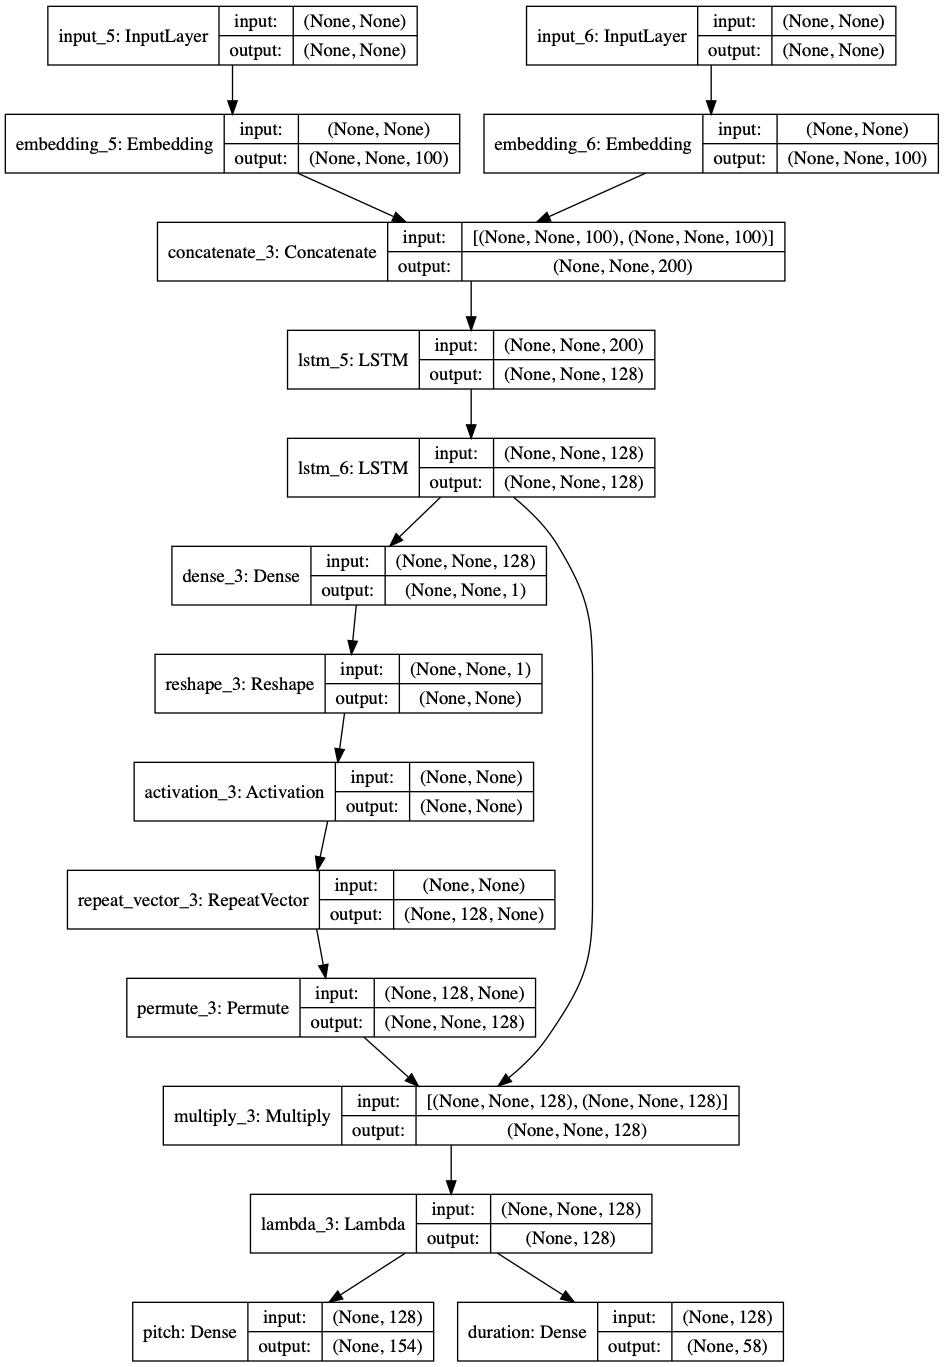

In [38]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [39]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [40]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )



/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6120 samples, validate on 1530 samples
Epoch 1/2000000
6120/6120 [==============================] - 41s 7ms/step - loss: 5.6904 - pitch_loss: 3.3854 - duration_loss: 2.3064 - val_loss: 5.4848 - val_pitch_loss: 3.3138 - val_duration_loss: 2.1770
Epoch 2/2000000
6120/6120 [==============================] - 41s 7ms/step - loss: 5.1665 - pitch_loss: 3.1170 - duration_loss: 2.0461 - val_loss: 5.4360 - val_pitch_loss: 3.2944 - val_duration_loss: 2.1483
Epoch 3/2000000
6120/6120 [==============================] - 41s 7ms/step - loss: 5.0881 - pitch_loss: 3.0773 - duration_loss: 2.0144 - val_loss: 5.5322 - val_pitch_loss: 3.3496 - val_duration_loss: 2.1884
Epoch 4/2000000
6120/6120 [==============================] - 41s 7ms/step - loss: 5.0456 - pitch_loss: 3.0527 - duration_loss: 1.9968 - val_loss: 5.4739 - val_pitch_loss: 3.3009 - val_duration_loss: 2.1798
Epoch 5/2000000
6120/6120 [==============================] - 42s 7ms/step - loss: 5.0072 - pitch_loss: 3.0343 - duration_loss: 1

6120/6120 [==============================] - 56s 9ms/step - loss: 3.6990 - pitch_loss: 2.1383 - duration_loss: 1.5606 - val_loss: 6.4913 - val_pitch_loss: 4.0761 - val_duration_loss: 2.4212
Epoch 41/2000000
6120/6120 [==============================] - 50s 8ms/step - loss: 3.6493 - pitch_loss: 2.1087 - duration_loss: 1.5390 - val_loss: 6.5654 - val_pitch_loss: 4.0726 - val_duration_loss: 2.4986
Epoch 42/2000000
6120/6120 [==============================] - 49s 8ms/step - loss: 3.6141 - pitch_loss: 2.0831 - duration_loss: 1.5307 - val_loss: 6.6028 - val_pitch_loss: 4.1336 - val_duration_loss: 2.4748
Epoch 43/2000000
6120/6120 [==============================] - 39s 6ms/step - loss: 3.5776 - pitch_loss: 2.0698 - duration_loss: 1.5106 - val_loss: 6.5883 - val_pitch_loss: 4.0787 - val_duration_loss: 2.5171
Epoch 44/2000000
6120/6120 [==============================] - 39s 6ms/step - loss: 3.5336 - pitch_loss: 2.0352 - duration_loss: 1.4951 - val_loss: 6.6934 - val_pitch_loss: 4.1727 - val_dura

KeyboardInterrupt: 